In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
import numpy as np
import os, shutil, glob, sys, math, cv2, re

import albumentations as albu
import pandas as pd
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict
# from torch.utils import load_state_dict_from_url
from torch.utils.model_zoo import load_url as load_state_dict_from_url
from torch import Tensor
from torch.jit.annotations import List
from torchsummary import summary
from torchvision import models


from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

# model

In [4]:
# 2D model
class classifier(nn.Module):
    def __init__(self, num_features = 100, nclass = 3):
        super().__init__()
        self.n_features = num_features
        self.wm = nn.Parameter(torch.Tensor(num_features, 512))
        self.dense1 = nn.Linear(512, 128)
        self.dense2 = nn.Linear(128, 16)
        self.dense3 = nn.Linear(16, nclass)
        self.act = nn.ReLU()
        
        self.wm = nn.init.normal_(self.wm)
    def forward(self,x):
        x = x.view(-1, self.n_features, 1)
        x = x * self.wm
    
        x = torch.mean(x, dim=1)
        x = self.dense1(x)
        x = self.act(x)
        x = self.dense2(x)
        x = self.act(x)
        x = self.dense3(x)
        return x

In [5]:
# model = classifier(num_features=60564)
# model.eval()
# inp = torch.randn(32,60564)
# a= model(inp)

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

In [6]:
# 2D model
class attentionPart(nn.Module):
    def __init__(self, d_model = 512):
        super().__init__()
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=8)

        self.attention_layer = nn.Sequential(
            nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=6),
            nn.AdaptiveMaxPool1d(1),
            Flatten(),
        )
       
    def forward(self, x):       
        attention = self.attention_layer(x)
        return attention

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [9]:
# 2D model
class classifier(nn.Module):
    def __init__(self, max_images = 200, d_model = 512, dropout=0.1, nclass=10):
        super().__init__()
        self.tumor_grade = 2
        self.max_images = max_images
        self.nclass = nclass
        self.CNN = vgg16_bn(pretrained = True)
#         self.CNN.load_state_dict(torch.load("./weight/vgg16_loss:CE_bs:25epoch:3_fscore:0.9987.h5"), strict = False)
     
        self.pos_encoder = PositionalEncoding(d_model=d_model, dropout=dropout, max_len=max_images)
        self.attention_layer = attentionPart(d_model)
        
        self.classify = nn.Sequential(
            nn.Linear(self.max_images + self.tumor_grade, 32),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(32, nclass)
        )
        # softmax
    def forward(self, x, y):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.CNN(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
#         print(r_in.shape)
        r_in = self.pos_encoder(r_in)
#         print(r_in.shape)
        attention = self.attention_layer(r_in)
#         print(attention.shape)
        attention = torch.cat((attention, y), 1)
        cls = self.classify(attention)
        return cls

# data

In [6]:
def cvt2Classy(label):
    cut = np.array([100,200])
    
    _foo = (label < cut)*1
    if np.sum(_foo) == 0:
        return len(cut)
    else:
        for _temp, _i in enumerate(_foo):
            if _i == 1:
                return _temp

In [7]:
# 數量500多，有些沒有images
import pandas as pd
df = pd.read_csv('./data/coad_Mutation_Count.txt', delimiter="\t")
cohort_count_dict = {row[1]: row[3] for index,row in df.iterrows()}

In [8]:
import pickle
with open('./no_RNA_no_onehot_other_feature.pkl', 'rb') as fp:
    cohort_other_feature_dict = pickle.load(fp)

In [9]:
train_cohorts, valid_cohorts = train_test_split(
    list(cohort_other_feature_dict.keys()), test_size=0.33, random_state=0)
print(len(train_cohorts), len(valid_cohorts))

239 118


# dataset

In [10]:
class Dataset(BaseDataset):
    
    def __init__(self, cohort, feature_dict, label_dict):
        self.cohort = cohort
        self.feature_dict = feature_dict
        self.label_dict = label_dict
        
    def __getitem__(self, i):
        cohort_name = self.cohort[i]
        feature = self.feature_dict[cohort_name]
        label = self.label_dict[cohort_name]
        label = cvt2Classy(label)
        return feature.astype('float32'), label
        
    def __len__(self):
        return len(self.cohort)

# model settings

In [11]:
import utils

In [12]:
bs = 32
epoch = 60
init_lr = 1e-5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

target = 'cls'
nclass = 3

nfeature = None
for key, value in cohort_other_feature_dict.items():
    if nfeature is None:
        nfeature = len(value)
    if nfeature != len(value):
        print("Error, feature number error")
print(nfeature)

17


In [13]:
model = classifier(num_features = nfeature, nclass = nclass)

In [14]:
train_dataset = Dataset(
    train_cohorts,
    cohort_other_feature_dict,
    cohort_count_dict
)

valid_dataset = Dataset(
    valid_cohorts,
    cohort_other_feature_dict,
    cohort_count_dict
)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, pin_memory=True, num_workers=0)

In [20]:
train_loss = 'ce'
train_metric = 'acc'

loss = utils.metrics.CrossEntropy(weight=class_weights.astype('float32'))
metrics = [
    utils.metrics.Accuracy(),
]


In [21]:
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=init_lr),
])

train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [22]:
# optimizer = torch.optim.Adam([ 
#     dict(params=model.parameters(), lr=init_lr),
# ])

# loss_f = nn.CrossEntropyLoss()
# metric_f = utils.metrics.Accuracy()

In [23]:
# for e in range(epoch):
#     model.train()
#     total_loss = 0
#     total_acc = 0
#     bts = 0
#     for data in train_loader:
#         feature, label = data
#         optimizer.zero_grad()
#         pred = model(feature)
#         loss = loss_f(pred, label)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.detach().cpu().numpy()
        
#         acc = metric_f(pred, label)
#         total_acc += acc.detach().cpu().numpy()
#         bts += 1
    # # model.eval()
    # # valid_bts = 0
    # # valid_loss = 0
    # # for data in valid_loader:
    # #     feature, label = data
    # #     with torch.no_grad():
    # #         pred = model(feature)
    # #         loss = loss_f(pred, label)
    # #     valid_loss += loss.detach().cpu().numpy()
    # #     valid_bts += 1
    # # print('Epoch {0} loss:{1:.4f} \r'.format(e, valid_loss / valid_bts))
#     print('Epoch {0} loss:{1:.4f} acc:{2:.4f} \r'.format(e, total_loss / bts, total_acc / bts))

Epoch 0 loss:9.2208 acc:0.4406 


KeyboardInterrupt: 

In [22]:
import time
current_time = time.strftime("%Y_%m_%d_%H_%M", time.localtime())

model_name = '/home/Tsung/pathology/weight/' + "{}_MCnt-{}-loss_{}_bs_{}".format(
    current_time, target, train_loss, bs)

cur_metric = 0

train_history = []
valid_history = []
for i in range(0, epoch):
    # adjust_learning_rate(optimizer, i)
    print('\nEpoch: {}, batch: {}'.format(i, bs))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_history.append(train_logs)
    valid_history.append(valid_logs)
#     lr_scheduler.step()
    
    if cur_metric < valid_logs[metrics[0].__name__]:
        cur_metric = valid_logs[metrics[0].__name__]
        torch.save(model.state_dict(), model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")
        print('Model saved!', model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")

    for param_group in optimizer.param_groups:
        print(param_group['lr'])
#     if cur_metric > valid_logs[metrics[0].__name__]:
#         cur_metric = valid_logs[metrics[0].__name__]
#         torch.save(model.state_dict(), model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")
#         print('Model saved!', model_name+"_epoch{}_{}:{:.4f}".format(i,train_metric, cur_metric)+".h5")


Epoch: 0, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 534.00it/s, cross entropy - 1.103, accuracy - 0.1783]
Model saved! /home/Tsung/pathology/weight/2020_10_07_12_12_MCnt-cls-loss_ce_bs_32_epoch0_acc:0.1783.h5
1e-05

Epoch: 1, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 544.33it/s, cross entropy - 1.098, accuracy - 0.1783]
1e-05

Epoch: 2, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 551.28it/s, cross entropy - 1.095, accuracy - 0.1939]
Model saved! /home/Tsung/pathology/weight/2020_10_07_12_12_MCnt-cls-loss_ce_bs_32_epoch2_acc:0.1939.h5
1e-05

Epoch: 3, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 557.36it/s, cross entropy - 1.093, accuracy - 0.1939]
1e-05

Epoch: 4, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 554.40it/s, cross entropy - 1.091, accuracy - 0.2017]
Model saved! /home/Tsung/pathology/weight/2020_10_07_12_12_MCnt-cls-loss_ce_bs_32_epoch4_acc:0.2017.h5
1e-05

Epoch: 5, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 561.15it/s, c

/home/Tsung/pathology/TMB/utils/metrics.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weight = torch.tensor(self.weight).cuda()


Model saved! /home/Tsung/pathology/weight/2020_10_07_12_12_MCnt-cls-loss_ce_bs_32_epoch5_acc:0.2287.h5
1e-05

Epoch: 6, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 531.72it/s, cross entropy - 1.088, accuracy - 0.2443]
Model saved! /home/Tsung/pathology/weight/2020_10_07_12_12_MCnt-cls-loss_ce_bs_32_epoch6_acc:0.2443.h5
1e-05

Epoch: 7, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 551.65it/s, cross entropy - 1.087, accuracy - 0.2756]
Model saved! /home/Tsung/pathology/weight/2020_10_07_12_12_MCnt-cls-loss_ce_bs_32_epoch7_acc:0.2756.h5
1e-05

Epoch: 8, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 553.10it/s, cross entropy - 1.086, accuracy - 0.2912]
Model saved! /home/Tsung/pathology/weight/2020_10_07_12_12_MCnt-cls-loss_ce_bs_32_epoch8_acc:0.2912.h5
1e-05

Epoch: 9, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 549.68it/s, cross entropy - 1.085, accuracy - 0.3608]
Model saved! /home/Tsung/pathology/weight/2020_10_07_12_12_MCnt-cls-loss_ce_bs_32_epoch9_acc:0.3

valid: 100%|██████████| 4/4 [00:00<00:00, 712.38it/s, cross entropy - 1.071, accuracy - 0.4616]
Model saved! /home/Tsung/pathology/weight/2020_10_07_12_12_MCnt-cls-loss_ce_bs_32_epoch37_acc:0.4616.h5
1e-05

Epoch: 38, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 692.16it/s, cross entropy - 1.07, accuracy - 0.4382]
1e-05

Epoch: 39, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 711.20it/s, cross entropy - 1.07, accuracy - 0.4382]
1e-05

Epoch: 40, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 683.33it/s, cross entropy - 1.07, accuracy - 0.446]
1e-05

Epoch: 41, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 714.17it/s, cross entropy - 1.07, accuracy - 0.446]
1e-05

Epoch: 42, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 710.75it/s, cross entropy - 1.069, accuracy - 0.446]
1e-05

Epoch: 43, batch: 32
valid: 100%|██████████| 4/4 [00:00<00:00, 709.13it/s, cross entropy - 1.069, accuracy - 0.4382]
1e-05

Epoch: 44, batch: 32
valid: 100%|██████████| 4/4 [00:00<

In [23]:
model.eval()

classifier(
  (dense1): Linear(in_features=512, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=16, bias=True)
  (dense3): Linear(in_features=16, out_features=3, bias=True)
  (act): ReLU()
)

In [28]:
for data in valid_loader:
    feature, label = data
    feature = feature.cuda()
    with torch.no_grad():
        pred = model(feature)
    pred = torch.softmax(pred, dim = 1)
    pred = torch.argmax(pred, dim = 1)
    pred = pred.detach().cpu().numpy()
    print(pred)
    

[0 2 1 2 2 2 2 1 0 1 0 1 0 0 1 2 1 2 0 1 0 1 0 0 2 2 0 0 1 1 2 0]


# plt

95
89
55


/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


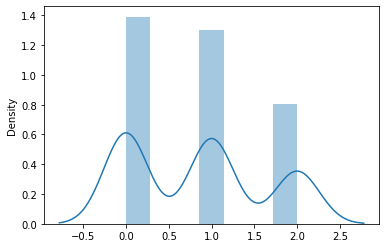

In [18]:
_temp = []
for i in train_cohorts:
    _temp.append(cvt2Classy(cohort_count_dict[i]))
_temp = np.array(_temp)

number_of_class = []
for i in range(3):
    print(np.count_nonzero(_temp == i))
    number_of_class.append(np.count_nonzero(_temp == i))
import seaborn as sns
sns.distplot(_temp)

In [19]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(_temp),
                                                 _temp)


52
47
19


/opt/conda/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


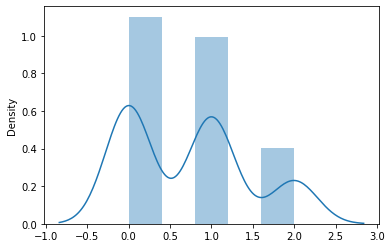

In [36]:
_temp = []
for i in valid_cohorts:
    _temp.append(cvt2Classy(cohort_count_dict[i]))
_temp = np.array(_temp)
for i in range(3):
    print(np.count_nonzero(_temp == i))
import seaborn as sns
sns.distplot(_temp)